In [4]:
from autoencoder import AutoEncoder
import yaml 
from pathlib import Path

In [5]:
path = 'logs/example/version_3'
checkpoint_path = list(Path(path, 'checkpoints').glob('*.ckpt'))[0]

In [6]:
with open(Path(path, 'hparams.yaml')) as file:
    hps = yaml.load(file, Loader=yaml.FullLoader)

In [7]:
ae = AutoEncoder(hps['encoder_layers'], hps['decoder_layers'], checkpoint_path=checkpoint_path)
ae.decoder.eval();

In [8]:
zdim = hps['encoder_layers'][-1]
zdim

4

In [9]:
from audio_utils import spectrogram2audio
from matplotlib import pyplot as plt
import torch
from IPython.display import Audio
import numpy as np



In [50]:
zs = []
z1 = torch.randn(1, zdim)
for i in range(10):
    z2 = torch.randn(1, zdim)
    for t in np.linspace(0,1,100):
        zs.append(torch.lerp(z1,z2,t))
    z1 = z2
    z2 = torch.randn(1, zdim)
frames = len(zs)
z = torch.vstack(zs)
print(z.shape)
with torch.no_grad():
    Y = ae.decoder(z)*hps['Xmax']

torch.Size([1000, 4])


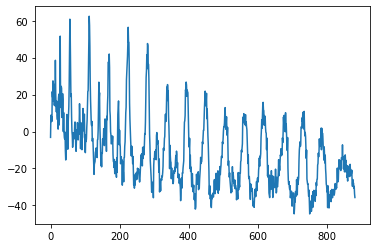

In [62]:

fc = 1
hl = hps['hop_length']*fc
wl = hps['win_length']*fc
Y_ = torch.nn.functional.interpolate(Y[:,None,:], (wl//2+1,))[:,0,:]
phase = torch.rand(Y_.shape[1])*torch.pi*2
grid = torch.meshgrid(torch.arange(0, frames,dtype=torch.float64), torch.zeros(Y_.shape[1],dtype=torch.float64))[0]

freqs = torch.linspace(0, hps['target_sampling_rate']//2, wl//2+1)
dt = hl/hps['target_sampling_rate']
phase = phase + freqs*2*torch.pi*dt*grid

phase = (torch.rand(Y_.shape)*2-1)*torch.pi
audio = spectrogram2audio(Y_,hps['db_min_norm'],phase,hl,wl,hps['spec_in_db']).cpu().numpy()
plt.plot(Y[0]+hps['db_min_norm'])
Audio(audio,rate=hps['target_sampling_rate'])

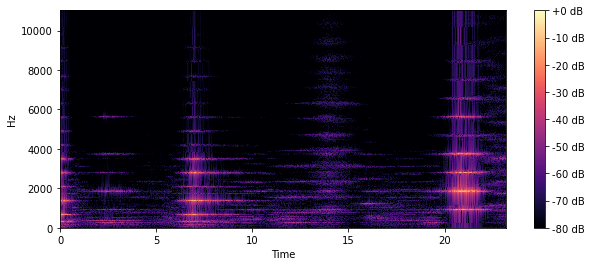

In [63]:

# use librosa and plot a spectrogram
import librosa
import librosa.display
import numpy as np

S = librosa.stft(y=audio, n_fft=hps['win_length'], hop_length=hps['hop_length'])
S_dB = librosa.power_to_db(np.abs(S)**2, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='linear', sr=hps['target_sampling_rate'])
plt.colorbar(format='%+2.0f dB')

